In [0]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

pd.set_option('display.max_columns',None)

In [0]:
def type_casting(data):
    df = data
    df['first_payment_date'] = pd.to_datetime(df.first_payment_date, format='%Y%m%d')
    df['origination_date'] = pd.to_datetime(df.origination_date, format='%Y%m%d')
#     df['test_type'] = df['test_type'].astype('object')
#     df['difficulty_level'] = df['difficulty_level'].astype('object')
    
    return(df)

def drop(data):
#     df = data.copy()
    df = data.drop(columns = ['loan_id','first_payment_date','origination_date'])
    
    return df

In [0]:
def label_enc(dataset):
    from sklearn.preprocessing import LabelEncoder
    df1 = dataset.copy()
    df_categorical = df1.select_dtypes(include=['object'])

    # apply Label encoder to df_categorical

    le = LabelEncoder()
    df_categorical = df_categorical.apply(le.fit_transform)
    df_categorical = df_categorical.astype('object')

    # concat df_categorical with original df AFTER LABEL ENCODING
    df1 = df1.drop(df_categorical.columns, axis=1)
    df1 = pd.concat([df1, df_categorical], axis=1)
    
    df_categorical =0
    return df1

def impute(data):
    from sklearn.impute import SimpleImputer
    
    si = SimpleImputer()
    array = si.fit_transform(data)
    
    return array
    

def standardize(dataset, X_test = None ,test = False):
    from sklearn.preprocessing import StandardScaler
    df1 = dataset.copy()
    df_num = df1.select_dtypes(include=['int64','float64','int32','float32'])
    df_num = pd.DataFrame(impute(df_num), columns = df_num.columns,index = df1.index)

    se = StandardScaler()
    df_scaled = pd.DataFrame(se.fit_transform(df_num),columns = df_num.columns, index = df_num.index)
    
    df_new = df1.drop(df_num.columns,axis =1)
    df_new = pd.concat([df_scaled,df_new],axis =1)
    
    if test:
        df1 = X_test.copy()
        df_test_num = X_test.select_dtypes(include=['int64','float64','int32','float32'])
        df_test_num = pd.DataFrame(impute(df_test_num), columns = df_test_num.columns,index = df_test_num.index)
        
        df_scaled = pd.DataFrame(se.transform(df_test_num),columns = df_test_num.columns, index = df_test_num.index)
        
        df_new_ = df1.drop(df_test_num.columns,axis =1)
        df_new_ = pd.concat([df_new_,df_scaled],axis =1)
    else:
        df_new_ = 0
    
#     df_num ,df1,df_scaled = 0    
    return df_new,df_new_

def over_sample(X_train, y_train, smote = True):
    X_os = pd.DataFrame(impute(X_train), columns = X_train.columns,index = X_train.index)  #smote does not accept null values, impute returns array
    y_os = y_train.copy()

    from imblearn.over_sampling import SMOTE,ADASYN
    if smote:
        os = SMOTE(random_state=0)
        columns = X_os.columns

        X_train_os,y_train_os=os.fit_sample(X_os, y_os)
        X_train_os = pd.DataFrame(data=X_train_os,columns=columns ) # both index changes , i think we dont need to change index
    
    else:
        os = ADASYN(random_state=0)
        columns = X_os.columns

        X_train_os,y_train_os=os.fit_sample(X_os, y_os)
        X_train_os = pd.DataFrame(data=X_train_os,columns=columns )
        
        
    return X_train_os, y_train_os

def under_sample(X_train, y_train, random_under_sample = True,random_replacement = False ,ver = 1):
    X_us = pd.DataFrame(impute(X_train), columns = X_train.columns,index = X_train.index)  #smote does not accept null values, impute returns array
    y_us = y_train.copy()

    from imblearn.under_sampling import RandomUnderSampler,NearMiss
    if random_under_sample:
        us = RandomUnderSampler(random_state=0, replacement = random_replacement)
        columns = X_us.columns

        X_train_us,y_train_us=us.fit_sample(X_us, y_us)
        X_train_us = pd.DataFrame(data=X_train_us,columns=columns ) # both index changes , i think we dont need to change index
    
    else:
        us = NearMiss(version = ver)
        columns = X_us.columns

        X_train_us,y_train_us=us.fit_sample(X_us, y_us)
        X_train_us = pd.DataFrame(data=X_train_us,columns=columns )
        
        
    return X_train_us, y_train_us

In [0]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [0]:
df_train = data_train.copy(deep = True)
df_test = data_test.copy(deep = True)

#v1

## checking

In [0]:
df_train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:
df_test.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1,Y,Browning-Hart,3.875,417000,360,01/02/12,Apr-12,75,1,20,790,A23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,X,OTHER,4.500,113000,360,01/02/12,Apr-12,80,2,33,793,C86,0,784,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,Y,OTHER,4.500,72000,360,01/01/12,Mar-12,75,1,34,710,C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,X,"Miller, Mcclure and Allen",4.125,123000,180,01/02/12,Apr-12,41,2,24,798,A23,0,813,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,X,Browning-Hart,3.250,166000,180,01/02/12,Apr-12,53,2,12,767,A23,0,768,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
'loan_id',

In [0]:
df = df_train.drop(columns=['loan_id','first_payment_date','origination_date'])

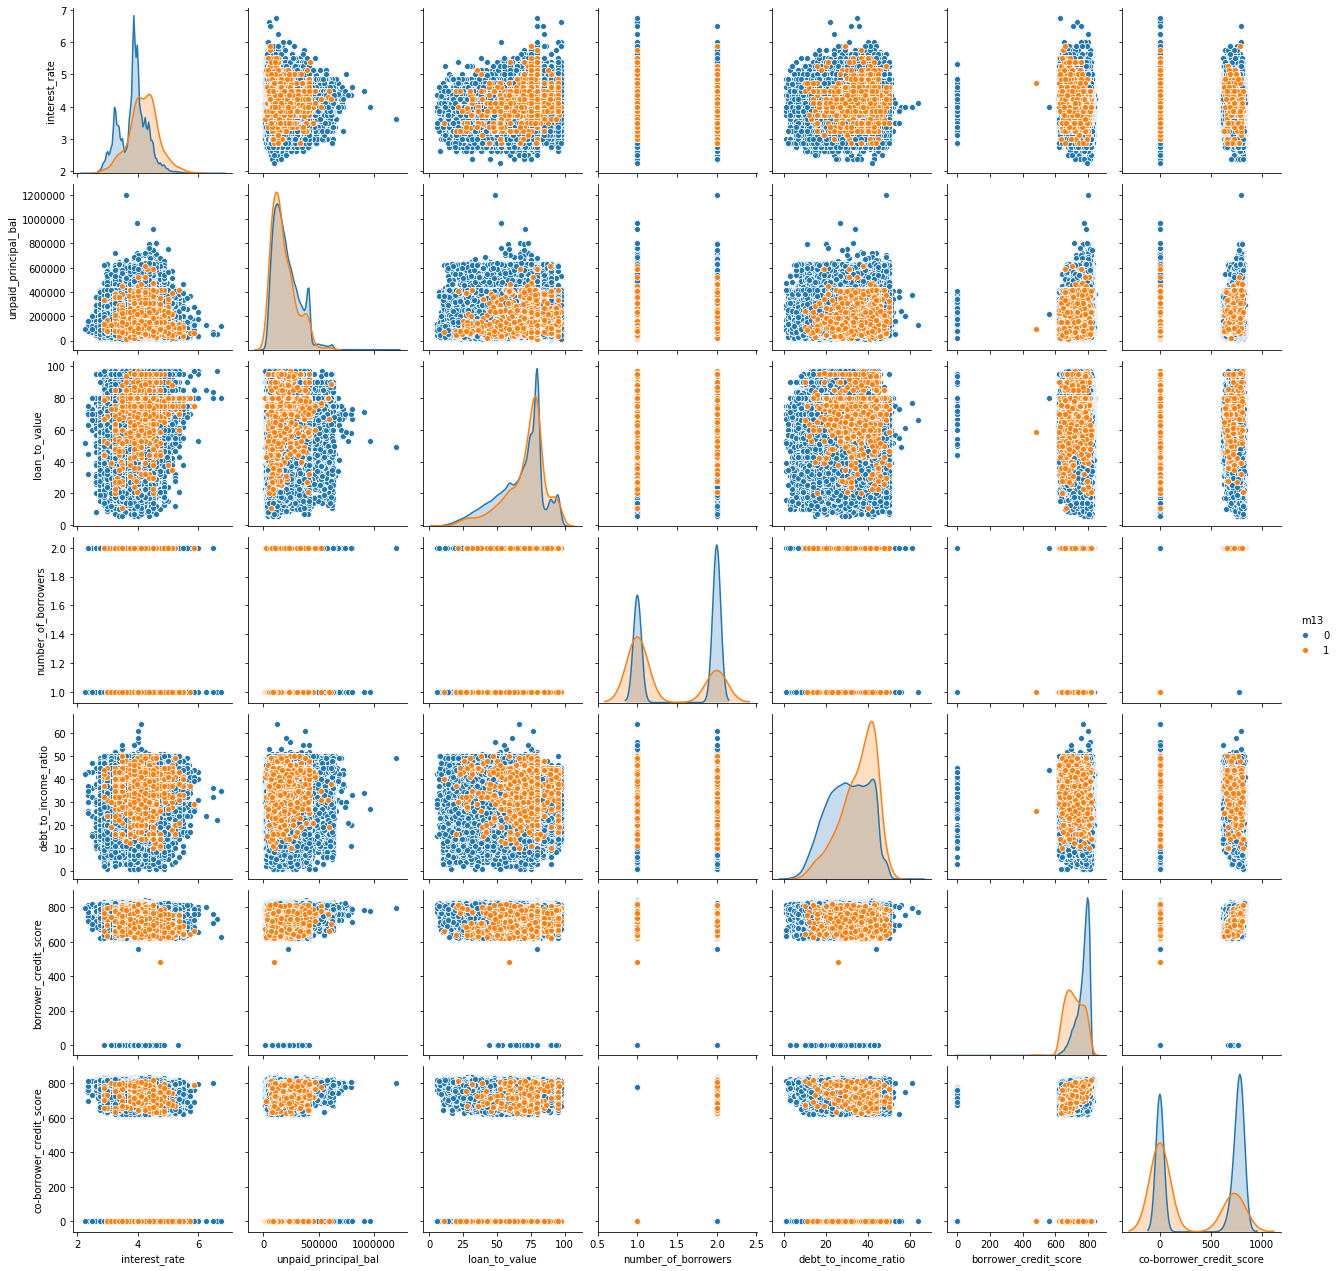

In [0]:
# sns.pairplot(df,hue = 'm13', diag_kind = 'kde', x_vars= ['interest_rate','unpaid_principal_bal','loan_to_value','number_of_borrowers','debt_to_income_ratio','borrower_credit_score','co-borrower_credit_score' ],y_vars= ['interest_rate','unpaid_principal_bal','loan_to_value','number_of_borrowers','debt_to_income_ratio','borrower_credit_score','co-borrower_credit_score' ])

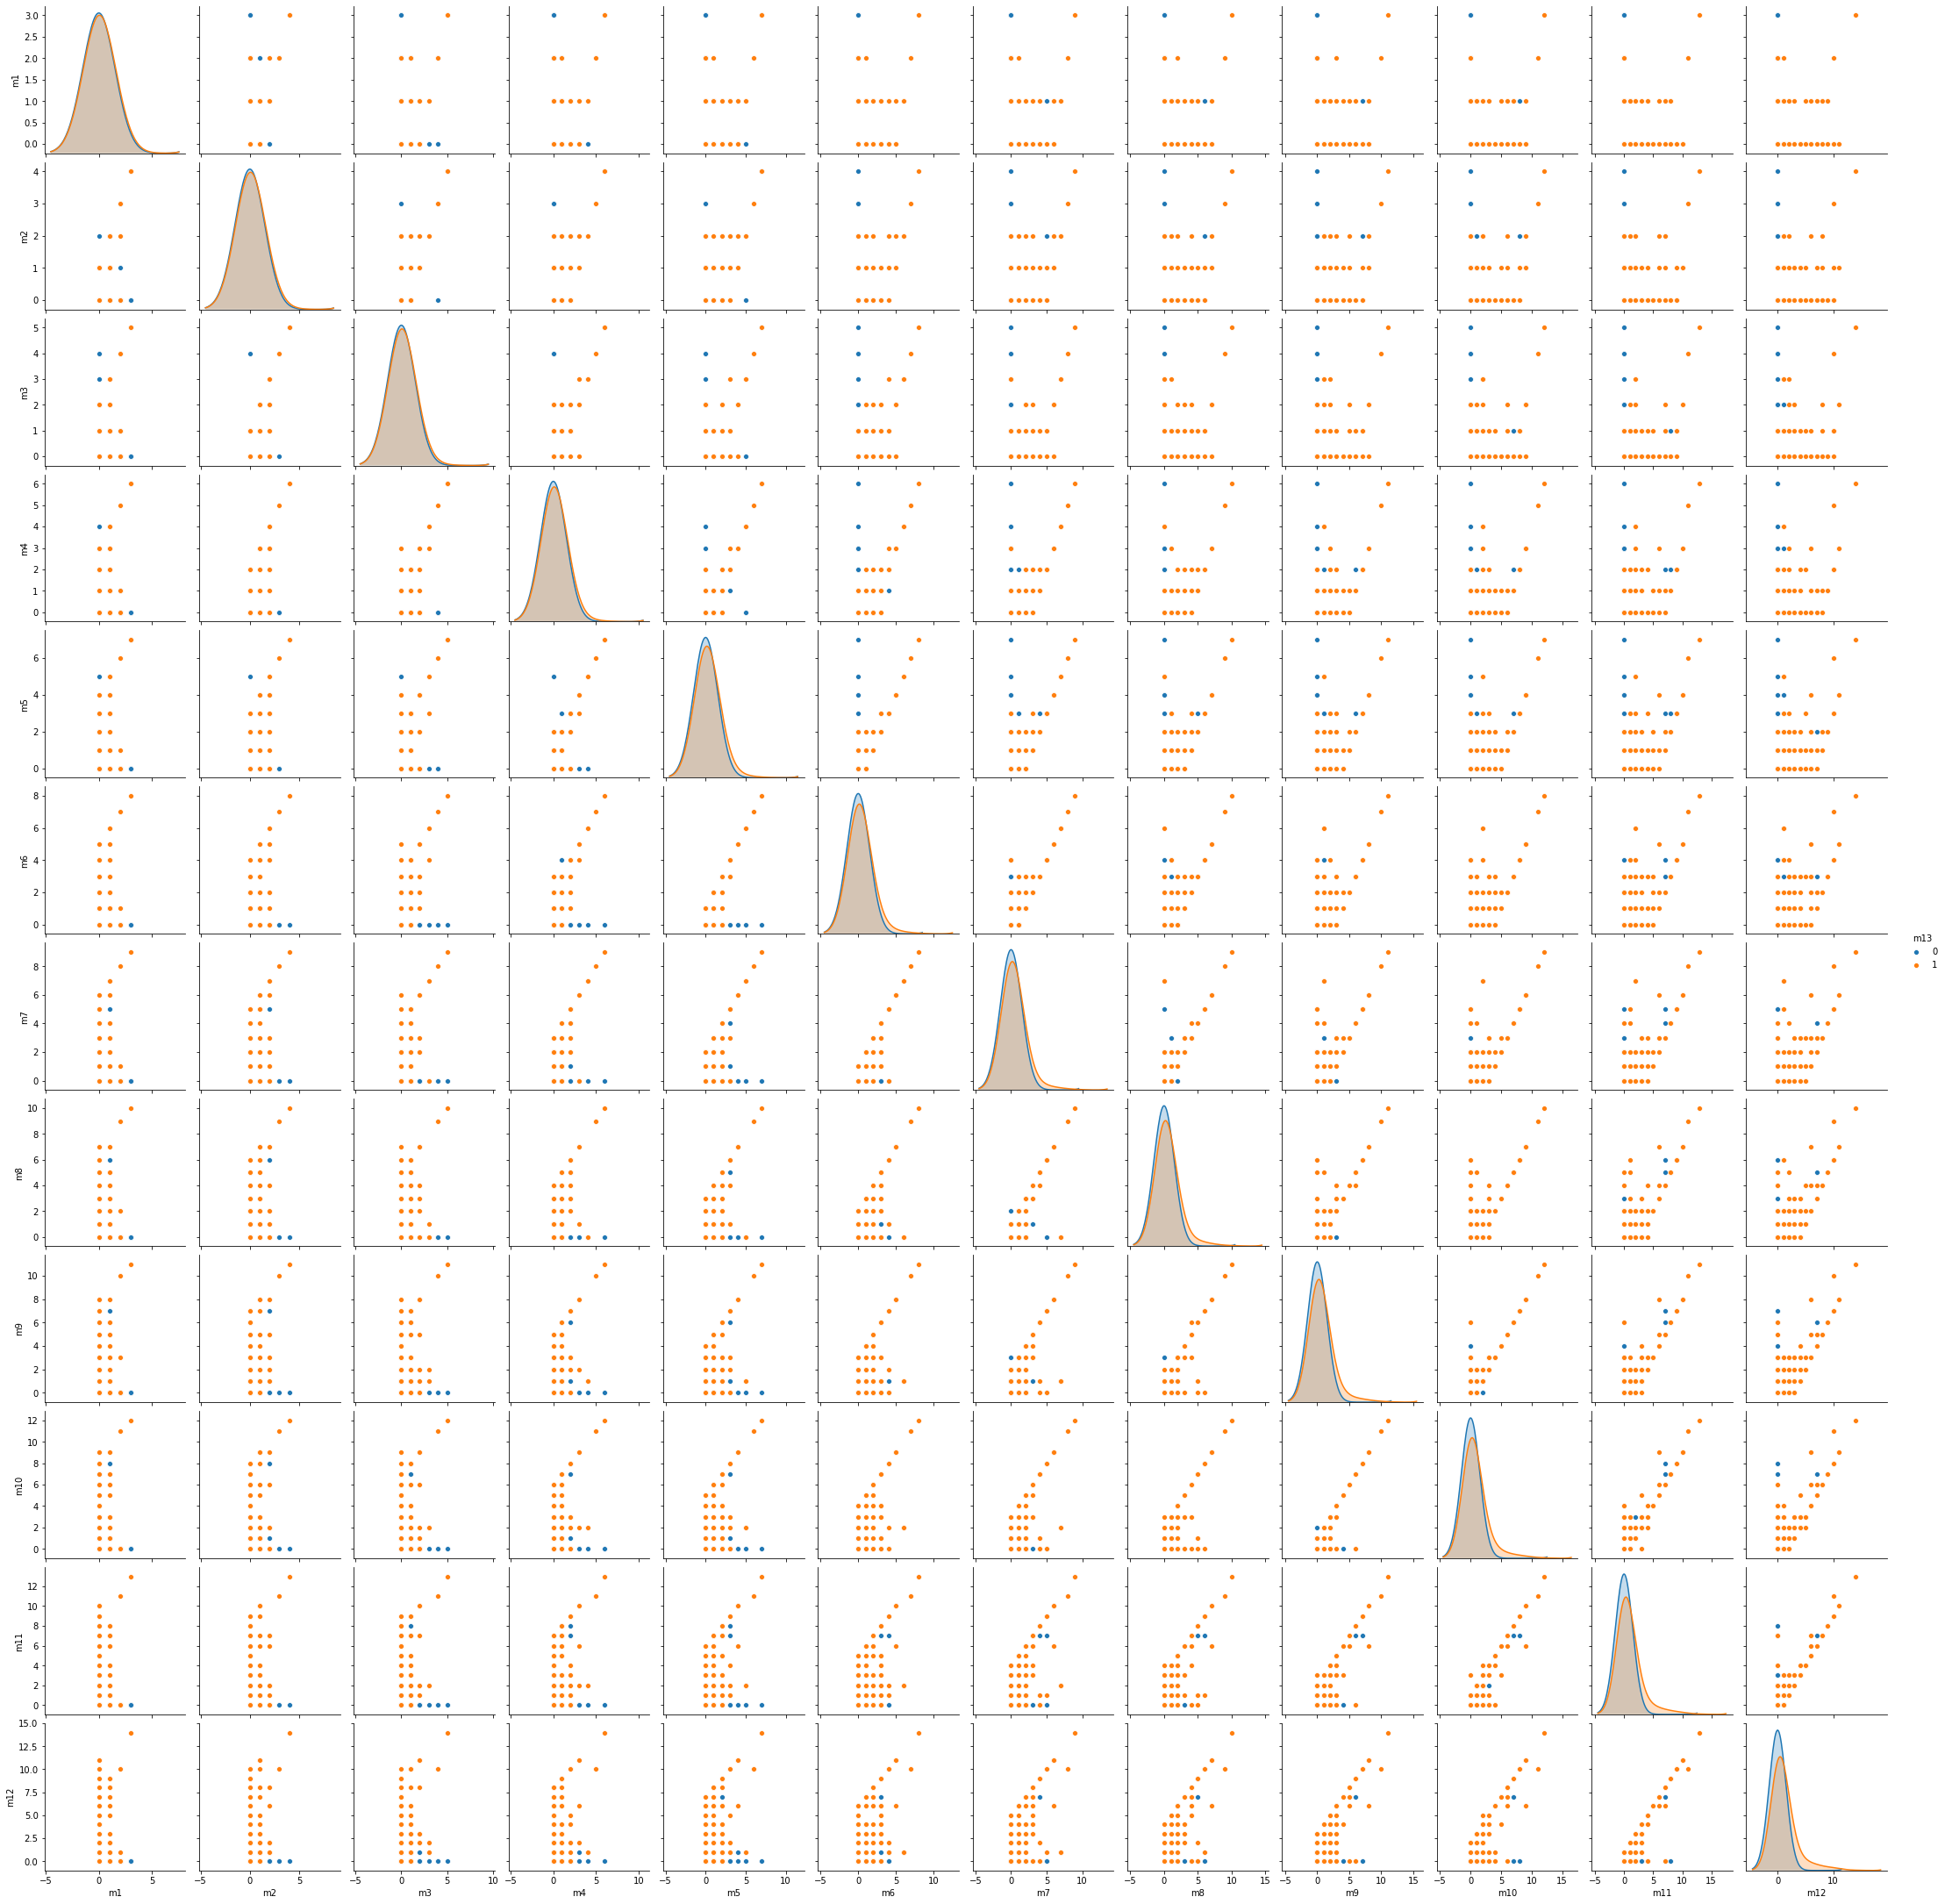

In [0]:
vars_ = ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']`
# sns.pairplot(df, diag_kind = 'kde',hue = 'm13', x_vars = vars_,y_vars = vars_, diag_kws={'bw':1.5})

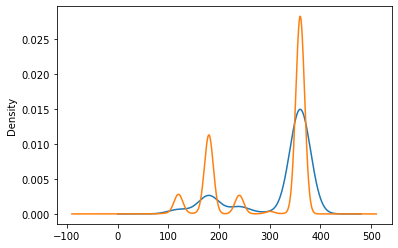

In [0]:
# df.loan_term[df.m13 == 1].plot(kind='kde')
# df.loan_term[df.m13 == 0].plot(kind='kde')

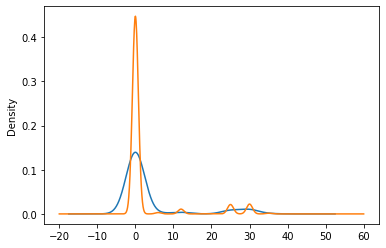

In [0]:
# df.insurance_percent[df.m13 == 1].plot(kind='kde')
# df.insurance_percent[df.m13 == 0].plot(kind='kde')

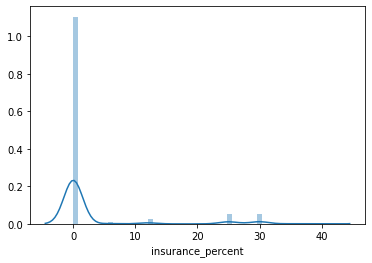

In [0]:
# sns.distplot(df.insurance_percent ,kde_kws={'bw':1.5})

In [0]:
del df_train['loan_id']

In [0]:
df_train.source.value_counts(), df_test.source.value_counts()

(X    63858
 Y    37554
 Z    14646
 Name: source, dtype: int64,
 X    19714
 Y    11653
 Z     4499
 Name: source, dtype: int64)

In [0]:
df_train.financial_institution.value_counts(), df_test.financial_institution.value_counts()

(OTHER                          49699
 Browning-Hart                  31852
 Swanson, Newton and Miller      6874
 Edwards-Hoffman                 4857
 Martinez, Duffy and Bird        4715
 Miller, Mcclure and Allen       3158
 Nicholson Group                 2116
 Turner, Baldwin and Rhodes      1846
 Suarez Inc                      1790
 Cole, Brooks and Vincent        1642
 Richards-Walters                1459
 Taylor, Hunt and Rodriguez      1259
 Sanchez-Robinson                1193
 Sanchez, Hays and Wilkerson      853
 Romero, Woods and Johnson        750
 Thornton-Davis                   651
 Anderson-Taylor                  483
 Richardson Ltd                   473
 Chapman-Mcmahon                  388
 Name: financial_institution, dtype: int64,
 OTHER                          15162
 Browning-Hart                  10078
 Swanson, Newton and Miller      2095
 Edwards-Hoffman                 1530
 Martinez, Duffy and Bird        1448
 Miller, Mcclure and Allen        912
 Nicho

In [0]:
df_train.loan_purpose.value_counts(), df_test.loan_purpose.value_counts()

(A23    58462
 B12    29383
 C86    28213
 Name: loan_purpose, dtype: int64,
 A23    17892
 B12     9197
 C86     8777
 Name: loan_purpose, dtype: int64)

In [0]:
df_train.origination_date.value_counts(), df_test.origination_date.value_counts()

(2012-02-01    52334
 2012-01-01    49093
 2012-03-01    14631
 Name: origination_date, dtype: int64,
 01/02/12    16423
 01/01/12    15051
 01/03/12     4392
 Name: origination_date, dtype: int64)

In [0]:
df_train.first_payment_date	.value_counts(), df_test.first_payment_date	.value_counts()

(04/2012    52840
 03/2012    47680
 05/2012    15014
 02/2012      524
 Name: first_payment_date, dtype: int64,
 Apr-12    16551
 Mar-12    14661
 May-12     4510
 Feb-12      144
 Name: first_payment_date, dtype: int64)

In [0]:
df_train.groupby('m13')['first_payment_date'].value_counts(normalize = True)

m13  first_payment_date
0    04/2012               0.455372
     03/2012               0.410528
     05/2012               0.129611
     02/2012               0.004488
1    03/2012               0.465409
     04/2012               0.440252
     05/2012               0.084906
     02/2012               0.009434
Name: first_payment_date, dtype: float64

In [0]:
df_train.groupby('m13')['origination_date'].value_counts(normalize = True)

m13  origination_date
0    2012-02-01          0.450997
     2012-01-01          0.422701
     2012-03-01          0.126302
1    2012-01-01          0.477987
     2012-02-01          0.438679
     2012-03-01          0.083333
Name: origination_date, dtype: float64

In [0]:
df_train['first_payment_date'] = pd.to_datetime(df_train.first_payment_date)    #func
df_train['first_payment_date'] = df_train['first_payment_date'].dt.month

In [0]:
df_train['origination_date'] = pd.to_datetime(df_train.origination_date)    #func
df_train['origination_date'] = df_train['origination_date'].dt.month

In [0]:
del df_train['loan_id']

In [0]:
df_train.groupby('m13')['first_payment_date'].value_counts(normalize = True), df_train.groupby('m13')['origination_date'].value_counts(normalize = True)

(m13  first_payment_date
 0    4                     0.455372
      3                     0.410528
      5                     0.129611
      2                     0.004488
 1    3                     0.465409
      4                     0.440252
      5                     0.084906
      2                     0.009434
 Name: first_payment_date, dtype: float64,
 m13  origination_date
 0    2                   0.450997
      1                   0.422701
      3                   0.126302
 1    1                   0.477987
      2                   0.438679
      3                   0.083333
 Name: origination_date, dtype: float64)

In [0]:
df_train

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,3,5,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,Y,"Swanson, Newton and Miller",4.875,144000,360,1,3,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,Z,Thornton-Davis,3.250,366000,180,1,3,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,X,OTHER,4.750,135000,360,2,4,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,X,OTHER,4.750,124000,360,2,4,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,Y,Browning-Hart,4.125,153000,360,2,4,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116054,Z,OTHER,3.000,150000,120,1,3,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116055,X,OTHER,3.875,166000,360,2,4,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116056,X,OTHER,4.250,169000,360,2,4,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df_tr_le = label_enc(df_train)

In [0]:
df_tr_le

,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,source,financial_institution,loan_purpose
0,4.250,214000,360,3,5,95,1.0,22.0,694.0,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,18,2
1,4.875,144000,360,1,3,72,1.0,44.0,697.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,15,1
2,3.250,366000,180,1,3,49,1.0,33.0,780.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,17,1
3,4.750,135000,360,2,4,46,2.0,44.0,633.0,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,8,1
4,4.750,124000,360,2,4,80,1.0,43.0,681.0,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1,0,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,4.125,153000,360,2,4,88,2.0,22.0,801.0,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
116054,3.000,150000,120,1,3,35,1.0,37.0,796.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,8,1
116055,3.875,166000,360,2,4,58,2.0,49.0,724.0,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,1
116056,4.250,169000,360,2,4,74,2.0,13.0,755.0,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0


In [0]:
df_tr_le[['source','financial_institution','loan_purpose']] = df_tr_le[['source','financial_institution','loan_purpose']].astype('object')

In [0]:
df_tr_le = pd.get_dummies(df_tr_le)

In [0]:
X = df_tr_le.drop(columns='m13')
y = df_tr_le.m13

In [0]:
X,_ = standardize(df_tr_le.drop(columns = 'm13'))

In [0]:
df_tr_le.m1.value_counts()

0    115729
1       293
2        30
3         6
Name: m1, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc  

In [0]:
X_train,X_val, y_train,y_val = train_test_split(X,y, random_state = 0)

In [0]:
def clf(model):
    from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
    
    model = model()
    model.fit(X_train, y_train)

    y_predict = model.predict(X_val)
    print(confusion_matrix(y_val,y_predict)) 
    print(accuracy_score(y_val,y_predict))
    
    fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
    print('auc :',auc(fpr, tpr))
    

In [0]:
clf(DecisionTreeClassifier)

[[28728   127]
 [   92    68]]
0.9924521799069447
auc : 0.7102993415352625


In [0]:
clf(RandomForestClassifier)

[[28850     5]
 [  104    56]]
0.9962433224194382
auc : 0.6749133599029632


In [0]:
clf(AdaBoostClassifier)

[[28840    15]
 [   99    61]]
0.9960709977597795
auc : 0.6903650797088894


In [0]:
clf(ExtraTreesClassifier)

[[28840    15]
 [  103    57]]
0.9959331380320524
auc : 0.6778650797088893


In [0]:
clf(KNeighborsClassifier)

[[28841    14]
 [  102    58]]
0.9960020678959159
auc : 0.6810074077282966


In [0]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(loss_function='MultiClass', 
                         eval_metric='Accuracy', 
                         depth=15,
                         random_seed=42, 
                         iterations=100, 
                         learning_rate=0.01,
                         leaf_estimation_iterations=1,
                         l2_leaf_reg=1,
                         bootstrap_type='Bayesian', 
                         bagging_temperature=1, 
                         random_strength=1,
                         od_type='Iter', 
                         od_wait=None)
cat.fit(X_train, y_train, verbose=10,
        use_best_model=True,
        eval_set=[(X_train, y_train),(X_val, y_val)],
        plot=False)

y_predict = cat.predict(X_val)
print(confusion_matrix(y_val,y_predict))
print('accuracy_score :' ,accuracy_score(y_val,y_predict))
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))

0:	learn: 0.9954505	test: 0.9954505	test1: 0.9950370	best: 0.9950370 (0)	total: 1.18s	remaining: 1m 56s
10:	learn: 0.9952667	test: 0.9952667	test1: 0.9951749	best: 0.9953472 (7)	total: 9.36s	remaining: 1m 15s
20:	learn: 0.9954620	test: 0.9954620	test1: 0.9953128	best: 0.9953472 (7)	total: 14.6s	remaining: 54.8s
30:	learn: 0.9954390	test: 0.9954390	test1: 0.9953128	best: 0.9954162 (24)	total: 22.9s	remaining: 51s
40:	learn: 0.9954390	test: 0.9954390	test1: 0.9953128	best: 0.9954162 (24)	total: 32.1s	remaining: 46.2s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.9954161641
bestIteration = 24

Shrink model to first 25 iterations.
[[28853     2]
 [  131    29]]
accuracy_score : 0.995416164053076
auc : 0.5905903439611853


##aw

In [0]:
data_train.head()

,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1


In [0]:
del data_train['loan_id']

In [0]:
del data_train['financial_institution']

In [0]:
data_train.m1.value_counts()

In [0]:
data_train.m2.value_counts()

In [0]:
data_train.m3.value_counts()

In [0]:
data_train

,source,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,Z,4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,Y,4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,Z,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,X,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,X,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,Y,4.125,153000,360,2012-02-01,04/2012,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116054,Z,3.000,150000,120,2012-01-01,03/2012,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116055,X,3.875,166000,360,2012-02-01,04/2012,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116056,X,4.250,169000,360,2012-02-01,04/2012,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data = data_train.drop(columns=['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','origination_date','first_payment_date'])

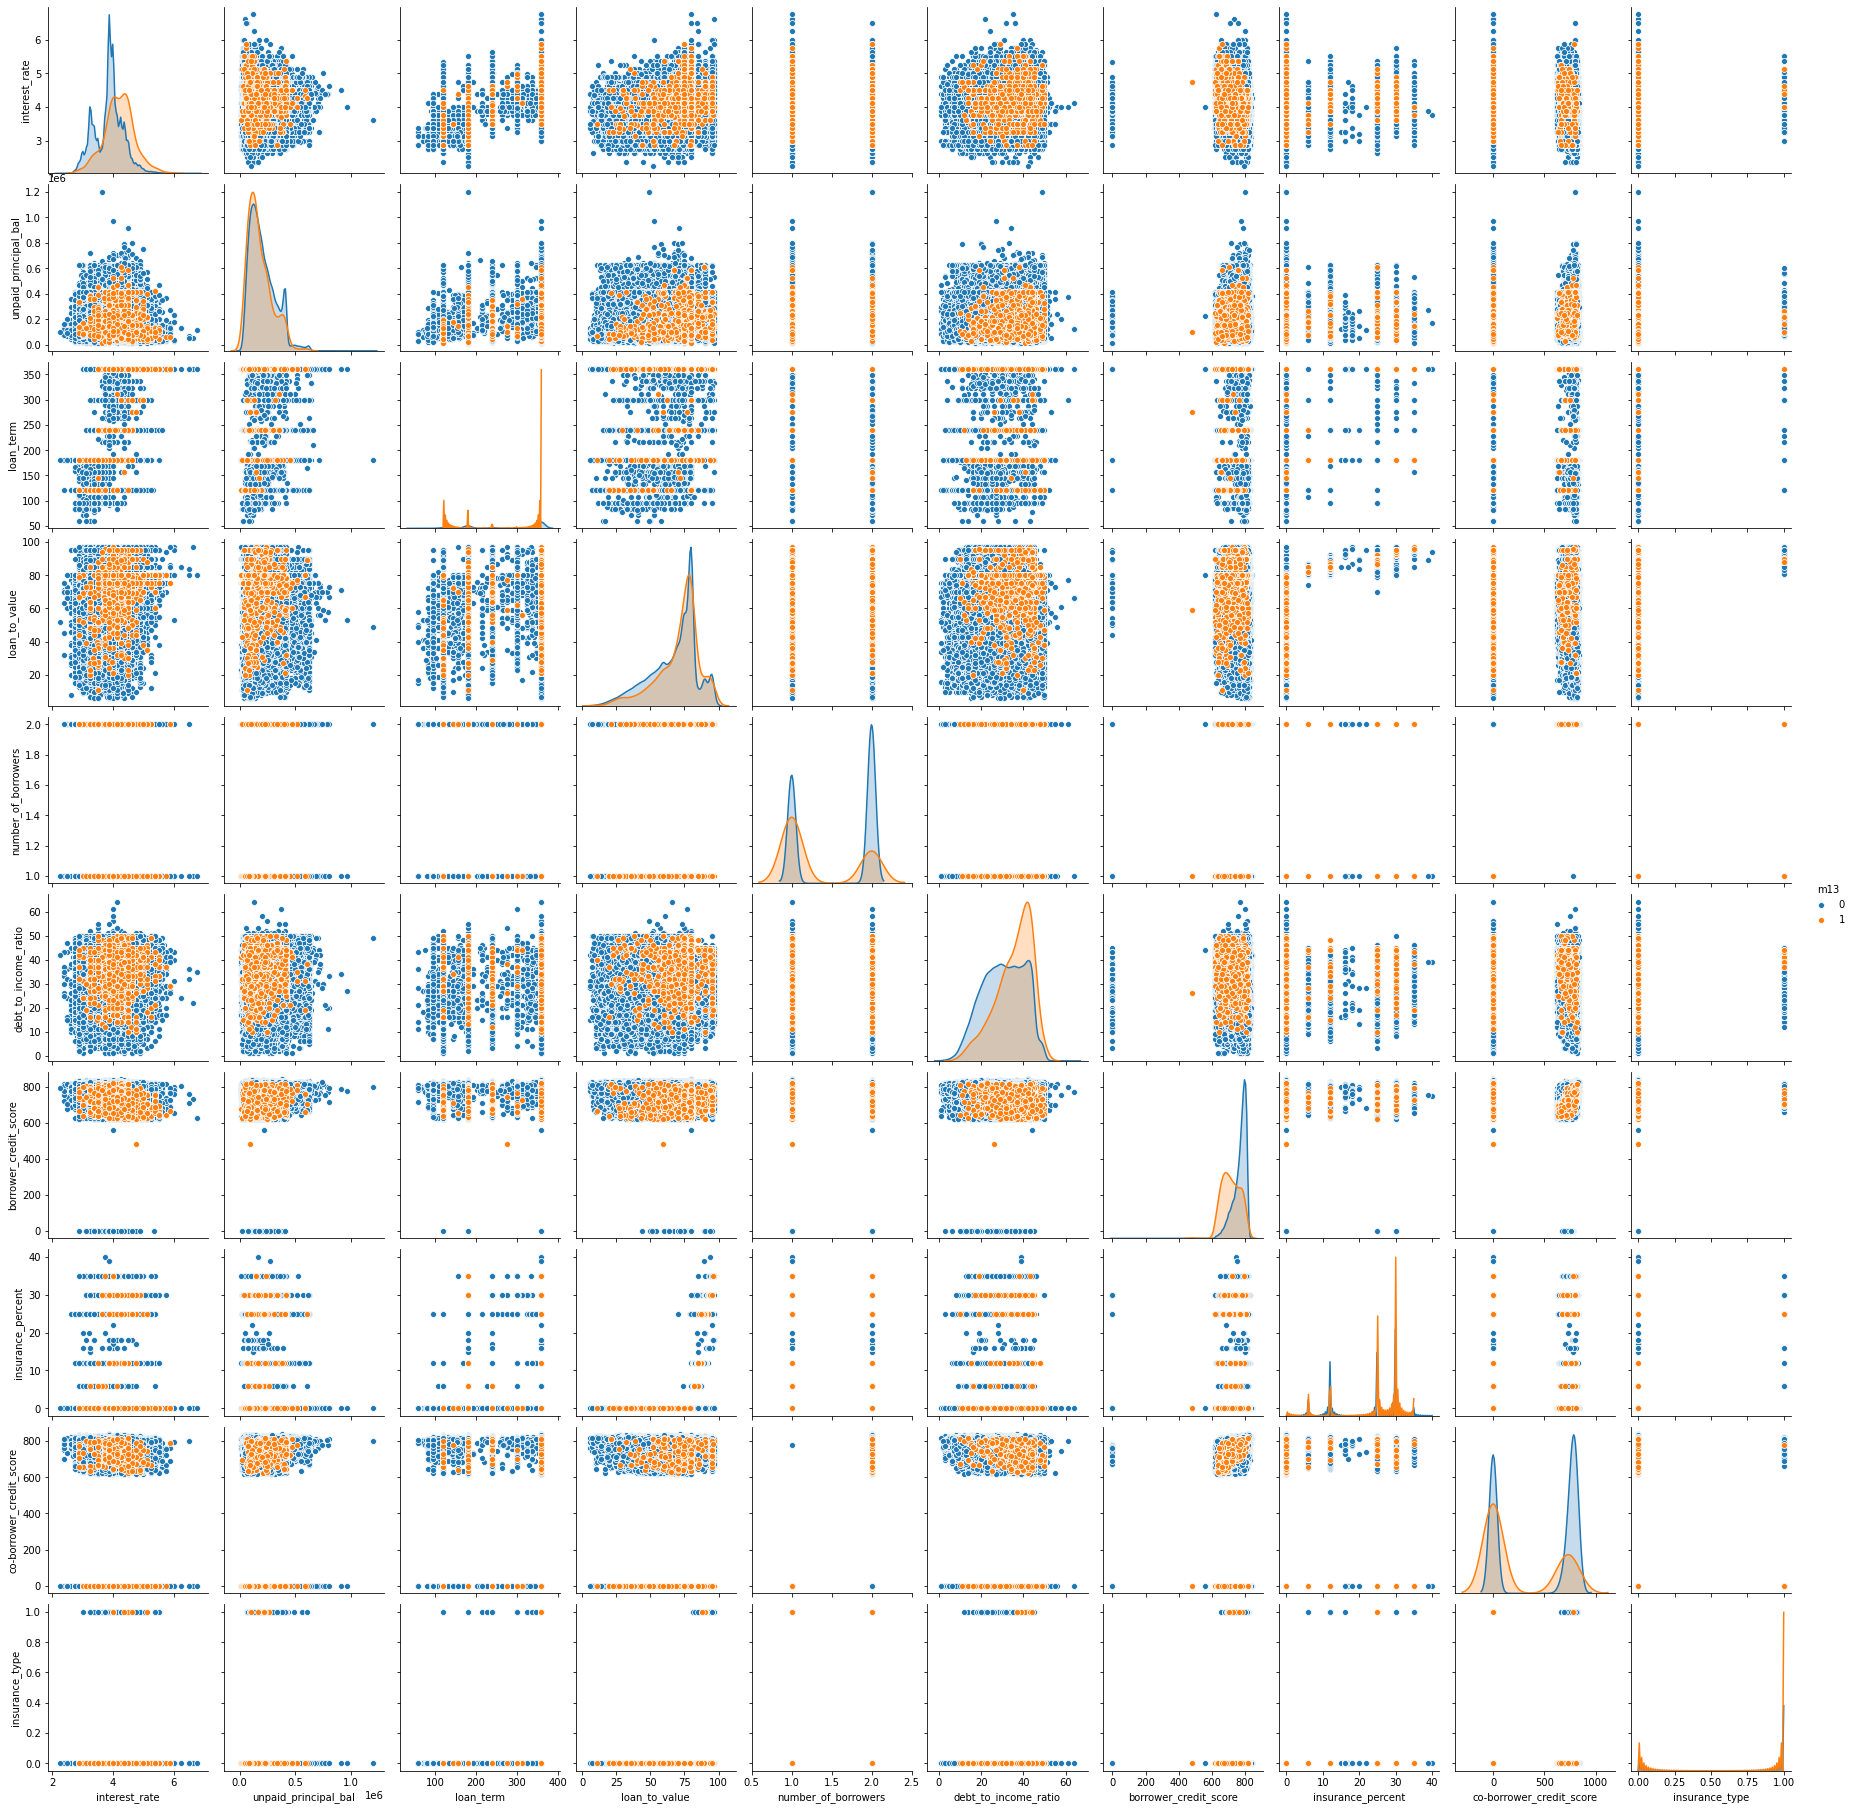

In [0]:
sns.pairplot(data ,diag_kind = 'kde', hue = 'm13')

In [0]:
data['previous_months_sum'] = data_train.m1 + data_train.m2 +data_train.m3 +data_train.m4 +data_train.m5 +data_train.m6 +data_train.m7 +data_train.m8 +data_train.m9 +data_train.m10 +data_train.m11 +data_train.m12

# v2

In [6]:
data_train

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,382119962287,Y,Browning-Hart,4.125,153000,360,2012-02-01,04/2012,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116054,582803915466,Z,OTHER,3.000,150000,120,2012-01-01,03/2012,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116055,837922316947,X,OTHER,3.875,166000,360,2012-02-01,04/2012,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0
116056,477343182138,X,OTHER,4.250,169000,360,2012-02-01,04/2012,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
data_train[['m10','m11','m12','m13']]

In [0]:
sns.pairplot(data_train, x_vars = ['m10','m11','m12'],y_vars= ['m10','m11','m12'] ,hue = 'm13')

In [193]:
data_train.groupby('financial_institution')['m13'].value_counts(normalize  =False   )

financial_institution        m13
Anderson-Taylor              0        480
                             1          3
Browning-Hart                0      31677
                             1        175
Chapman-Mcmahon              0        388
Cole, Brooks and Vincent     0       1630
                             1         12
Edwards-Hoffman              0       4816
                             1         41
Martinez, Duffy and Bird     0       4692
                             1         23
Miller, Mcclure and Allen    0       3139
                             1         19
Nicholson Group              0       2105
                             1         11
OTHER                        0      49430
                             1        269
Richards-Walters             0       1454
                             1          5
Richardson Ltd               0        472
                             1          1
Romero, Woods and Johnson    0        748
                             1          2
S

In [0]:
data_train.groupby('source')['m13'].value_counts(normalize  =True)

In [0]:
data_train.groupby('loan_purpose')['m13'].value_counts(normalize  =True)

In [0]:
data_train.groupby('insurance_type')['m13'].value_counts(normalize  =True)

In [0]:
data_train.groupby('insurance_percent')['m13'].value_counts(normalize  =True)

In [0]:
data_train.groupby('origination_date')['m13'].value_counts(normalize  =True)

In [0]:
data_train.groupby('first_payment_date')['m13'].value_counts(normalize  =True)

In [0]:
data_train.groupby('loan_term')['m13'].value_counts(normalize  =True).tail(50)

In [0]:
data_train.groupby('number_of_borrowers')['m13'].value_counts(normalize  =False)

In [38]:
data_train.groupby('m13')['m12'].value_counts(normalize  =False)

m13  m12
0    0      115221
     1         194
     2           4
     4           1
     6           1
     7           1
1    0         336
     1         172
     2          43
     3          28
     4          14
     6          13
     5           7
     7           6
     8           5
     10          5
     9           3
     11          3
     14          1
Name: m12, dtype: int64

In [0]:
data_train['m12_mod'] = data_train['m12']> 3

In [0]:
data_train.m12_mod = data_train.m12_mod.astype('int')

In [142]:
data_train.groupby('m13')['m12_mod'].value_counts(normalize  =False)

m13  m12_mod
0    0          115419
     1               3
1    0             579
     1              57
Name: m12_mod, dtype: int64

In [39]:
data_train.groupby('m13')['m11'].value_counts(normalize  =False)

m13  m11
0    0      115211
     1         197
     2           6
     3           4
     7           2
     5           1
     8           1
1    0         401
     1         123
     2          42
     3          22
     4          11
     5          11
     6           7
     7           7
     9           4
     8           3
     10          3
     11          1
     13          1
Name: m11, dtype: int64

In [0]:
data_train['m11_mod'] = data_train['m11']> 1

In [0]:
data_train.m11_mod = data_train.m11_mod.astype('int')

In [69]:
data_train.groupby('m13')['m11_mod'].value_counts(normalize  =False)

m13  m11_mod
0    0          115408
     1              14
1    0             524
     1             112
Name: m11_mod, dtype: int64

In [40]:
data_train.groupby('m13')['m11'].value_counts(normalize  =False)

m13  m11
0    0      115211
     1         197
     2           6
     3           4
     7           2
     5           1
     8           1
1    0         401
     1         123
     2          42
     3          22
     4          11
     5          11
     6           7
     7           7
     9           4
     8           3
     10          3
     11          1
     13          1
Name: m11, dtype: int64

In [0]:
data_train['m10_mod'] = data_train['m10']> 1

In [0]:
data_train.m10_mod = data_train.m10_mod.astype('int')

In [78]:
data_train.groupby('m13')['m10_mod'].value_counts(normalize  =False)

m13  m10_mod
0    0          115398
     1              24
1    0             540
     1              96
Name: m10_mod, dtype: int64

In [41]:
data_train.groupby('m13')['m10'].value_counts(normalize  =False)

m13  m10
0    0      115172
     1         226
     2          16
     3           4
     7           2
     4           1
     8           1
1    0         441
     1          99
     2          38
     3          17
     4          14
     6           8
     5           6
     8           4
     9           4
     7           3
     11          1
     12          1
Name: m10, dtype: int64

In [0]:
data_train['m9_mod'] = data_train['m9']> 1

In [0]:
data_train.m9_mod = data_train.m9_mod.astype('int')

In [87]:
data_train.groupby('m13')['m9_mod'].value_counts(normalize  =False)

m13  m9_mod
0    0         115405
     1             17
1    0            555
     1             81
Name: m9_mod, dtype: int64

In [0]:
data_train['m8_mod'] = data_train['m8']> 1

In [0]:
data_train.m8_mod = data_train.m8_mod.astype('int')

In [90]:
data_train.groupby('m13')['m8_mod'].value_counts(normalize  =False)

m13  m8_mod
0    0         115406
     1             16
1    0            564
     1             72
Name: m8_mod, dtype: int64

In [0]:
data_train['old_all'] = (data_train.m1 + data_train.m2 +data_train.m3 +data_train.m4 +data_train.m5 +data_train.m6 +data_train.m7 +data_train.m8 +data_train.m9 +data_train.m10 +data_train.m11 +data_train.m12) > 1

In [0]:
data_train['old_all'] = data_train['old_all'].astype('int')

In [136]:
data_train.groupby('old_all')['m13'].value_counts(normalize  =False)

old_all  m13
0        0      115050
         1         334
1        0         372
         1         302
Name: m13, dtype: int64

In [0]:
data_train['old_sum'] = (data_train.m1 + data_train.m2 +data_train.m3 +data_train.m4 +data_train.m5 +data_train.m6 +data_train.m7 +data_train.m8 +data_train.m9 +data_train.m10 +data_train.m11 +data_train.m12) 

In [147]:
data_train

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m12_mod,m11_mod,m10_mod,m9_mod,m8_mod,old_all,old_sum
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,4
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1,1,1,1,1,1,1,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,382119962287,Y,Browning-Hart,4.125,153000,360,2012-02-01,04/2012,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116054,582803915466,Z,OTHER,3.000,150000,120,2012-01-01,03/2012,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116055,837922316947,X,OTHER,3.875,166000,360,2012-02-01,04/2012,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116056,477343182138,X,OTHER,4.250,169000,360,2012-02-01,04/2012,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
data_train.groupby('m13')['old_sum'].value_counts(normalize  =False).head(50)

m13  old_sum
0    0          113814
     1            1236
     2             191
     3              87
     4              32
     6              17
     5              16
     9               7
     8               6
     11              3
     7               2
     12              2
     16              2
     10              1
     14              1
     21              1
     25              1
     39              1
     42              1
     46              1
1    0             233
     1             101
     2              55
     3              35
     6              32
     4              21
     5              16
     7              15
     9              13
     8              12
     10             11
     11             10
     21              9
     12              8
     14              6
     15              6
     17              4
     55              4
     24              3
     28              3
     34              3
     36              3
     66              

In [0]:
df = data_train.copy(deep = True)

In [167]:
df

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m12_mod,m11_mod,m10_mod,m9_mod,m8_mod,old_all,old_sum
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,4
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,2,3,4,5,6,7,8,9,10,11,1,1,1,1,1,1,1,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,382119962287,Y,Browning-Hart,4.125,153000,360,2012-02-01,04/2012,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116054,582803915466,Z,OTHER,3.000,150000,120,2012-01-01,03/2012,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116055,837922316947,X,OTHER,3.875,166000,360,2012-02-01,04/2012,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116056,477343182138,X,OTHER,4.250,169000,360,2012-02-01,04/2012,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
for i in ['m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12']:
    df[i] = df[i] > 0
    df[i] = df[i].astype('int')

In [169]:
df

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m12_mod,m11_mod,m10_mod,m9_mod,m8_mod,old_all,old_sum
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,4
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,382119962287,Y,Browning-Hart,4.125,153000,360,2012-02-01,04/2012,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116054,582803915466,Z,OTHER,3.000,150000,120,2012-01-01,03/2012,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116055,837922316947,X,OTHER,3.875,166000,360,2012-02-01,04/2012,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116056,477343182138,X,OTHER,4.250,169000,360,2012-02-01,04/2012,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
df['old_sum'] = (df.m1 +df.m2 +df.m3 +df.m4 +df.m5 +df.m6 +df.m7 +df.m8 +df.m9 +df.m10 +df.m11 +df.m12) 
df['old_all'] = (df.m1 +df.m2 +df.m3 +df.m4 +df.m5 +df.m6 +df.m7 +df.m8 +df.m9 +df.m10 +df.m11 +df.m12) > 3
df['old_all'] = df['old_all'].astype('int')

In [180]:
df

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m12_mod,m11_mod,m10_mod,m9_mod,m8_mod,old_all,old_sum
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,4
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,382119962287,Y,Browning-Hart,4.125,153000,360,2012-02-01,04/2012,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116054,582803915466,Z,OTHER,3.000,150000,120,2012-01-01,03/2012,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116055,837922316947,X,OTHER,3.875,166000,360,2012-02-01,04/2012,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116056,477343182138,X,OTHER,4.250,169000,360,2012-02-01,04/2012,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [181]:
df.groupby('m13')['old_sum'].value_counts(normalize  =False).head(50)

m13  old_sum
0    0          113814
     1            1269
     2             189
     3              79
     4              27
     5              19
     6              12
     7               5
     9               4
     8               3
     11              1
1    0             233
     1             101
     2              71
     5              41
     4              35
     3              30
     6              28
     7              27
     8              22
     9              17
     11             14
     10             11
     12              6
Name: old_sum, dtype: int64

In [182]:
df.groupby('m13')['old_all'].value_counts(normalize  =False).head(50)

m13  old_all
0    0          115351
     1              71
1    0             435
     1             201
Name: old_all, dtype: int64

In [0]:
df['last5_sum'] = (df.m9 +df.m10 +df.m11 +df.m12) 
df['last5'] = (df.m9 +df.m10 +df.m11 +df.m12) > 0
df['last5'] = df['last5'].astype('int')

In [187]:
df

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m12_mod,m11_mod,m10_mod,m9_mod,m8_mod,old_all,old_sum,last5_sum,last5
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,4,4,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,11,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,382119962287,Y,Browning-Hart,4.125,153000,360,2012-02-01,04/2012,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116054,582803915466,Z,OTHER,3.000,150000,120,2012-01-01,03/2012,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116055,837922316947,X,OTHER,3.875,166000,360,2012-02-01,04/2012,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
116056,477343182138,X,OTHER,4.250,169000,360,2012-02-01,04/2012,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [188]:
df.groupby('m13')['last5'].value_counts(normalize  =False).head(50)

m13  last5
0    0        114750
     1           672
1    1           369
     0           267
Name: last5, dtype: int64

In [190]:
df.groupby('last5')['m13'].value_counts(normalize  =False).head(50)

last5  m13
0      0      114750
       1         267
1      0         672
       1         369
Name: m13, dtype: int64

In [189]:
df.groupby('last5_sum')['m13'].value_counts(normalize  =False).head(50)

last5_sum  m13
0          0      114750
           1         267
1          0         552
           1         114
2          1          84
           0          78
3          1          43
           0          36
4          1         128
           0           6
Name: m13, dtype: int64

In [191]:
df.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m12_mod,m11_mod,m10_mod,m9_mod,m8_mod,old_all,old_sum,last5_sum,last5
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,4,4,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,11,4,1


In [0]:
data = df.drop(columns= ['loan_id','financial_institution','origination_date','first_payment_date','m1','m2','m3','m4','m5','m6','m7','m8','m9','m10','m11','m12','m12_mod','m11_mod','m10_mod','m9_mod','m8_mod','old_all','old_sum'])

In [198]:
data

,source,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,loan_purpose,insurance_percent,co-borrower_credit_score,insurance_type,m13,last5_sum,last5
0,Z,4.250,214000,360,95,1.0,22.0,694.0,C86,30.0,0.0,0.0,1,0,0
1,Y,4.875,144000,360,72,1.0,44.0,697.0,B12,0.0,0.0,0.0,1,1,1
2,Z,3.250,366000,180,49,1.0,33.0,780.0,B12,0.0,0.0,0.0,1,0,0
3,X,4.750,135000,360,46,2.0,44.0,633.0,B12,0.0,638.0,0.0,1,4,1
4,X,4.750,124000,360,80,1.0,43.0,681.0,C86,0.0,0.0,0.0,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,Y,4.125,153000,360,88,2.0,22.0,801.0,A23,25.0,802.0,0.0,0,0,0
116054,Z,3.000,150000,120,35,1.0,37.0,796.0,B12,0.0,0.0,0.0,0,0,0
116055,X,3.875,166000,360,58,2.0,49.0,724.0,B12,0.0,723.0,0.0,0,0,0
116056,X,4.250,169000,360,74,2.0,13.0,755.0,A23,0.0,746.0,0.0,0,0,0


In [0]:
data_num = data.select_dtypes(exclude='object')

In [0]:
X = data_num.drop(columns='m13')

In [0]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [221]:
X = add_constant(X)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                       1724.604630
interest_rate                  2.337790
unpaid_principal_bal           1.122459
loan_term                      2.361811
loan_to_value                  1.432283
number_of_borrowers          172.211575
debt_to_income_ratio           1.088439
borrower_credit_score          1.300145
insurance_percent              1.347002
co-borrower_credit_score     174.244523
insurance_type                 1.025199
last5_sum                      3.505250
last5                          3.505573
dtype: float64

In [0]:
data_vif = data.drop(columns=['number_of_borrowers'])

In [228]:
data_num = data_vif.select_dtypes(exclude='object')
X = data_num.drop(columns='m13')

X = add_constant(X)
pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)

const                       585.778235
interest_rate                 2.334001
unpaid_principal_bal          1.122415
loan_term                     2.358904
loan_to_value                 1.430287
debt_to_income_ratio          1.084950
borrower_credit_score         1.121289
insurance_percent             1.346906
co-borrower_credit_score      1.078283
insurance_type                1.025173
last5_sum                     3.504881
last5                         3.505400
dtype: float64

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc,classification_report

In [0]:
data_new = data.drop(columns=['number_of_borrowers'])

In [0]:
data_new['last5'] = data_new['last5'].astype('object')

In [0]:
data_dumm = pd.get_dummies(data_new)

In [286]:
data_dumm

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,m13,last5_sum,source_X,source_Y,source_Z,loan_purpose_A23,loan_purpose_B12,loan_purpose_C86,last5_0,last5_1
0,4.250,214000,360,95,22.0,694.0,30.0,0.0,0.0,1,0,0,0,1,0,0,1,1,0
1,4.875,144000,360,72,44.0,697.0,0.0,0.0,0.0,1,1,0,1,0,0,1,0,0,1
2,3.250,366000,180,49,33.0,780.0,0.0,0.0,0.0,1,0,0,0,1,0,1,0,1,0
3,4.750,135000,360,46,44.0,633.0,0.0,638.0,0.0,1,4,1,0,0,0,1,0,0,1
4,4.750,124000,360,80,43.0,681.0,0.0,0.0,0.0,1,4,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116053,4.125,153000,360,88,22.0,801.0,25.0,802.0,0.0,0,0,0,1,0,1,0,0,1,0
116054,3.000,150000,120,35,37.0,796.0,0.0,0.0,0.0,0,0,0,0,1,0,1,0,1,0
116055,3.875,166000,360,58,49.0,724.0,0.0,723.0,0.0,0,0,1,0,0,0,1,0,1,0
116056,4.250,169000,360,74,13.0,755.0,0.0,746.0,0.0,0,0,1,0,0,1,0,0,1,0


In [0]:
def clf(model):
    from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc,classification_report
    
    model = model()
    model.fit(X_train, y_train)

    y_predict = model.predict(X_val)
    print(confusion_matrix(y_val,y_predict)) 
    print(accuracy_score(y_val,y_predict))
    
    fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
    print('auc :',auc(fpr, tpr))
    
    print(classification_report(y_val, y_predict))

In [0]:
## without normalization

X_nothing = data_dumm.drop('m13',axis= 1)
y = data_dumm['m13']

X_train,X_val, y_train,y_val = train_test_split(X_nothing,y, random_state = 0, train_size = 0.9)


In [299]:
clf(DecisionTreeClassifier)

[[11490    48]
 [   45    23]]
0.9919869033258659
auc : 0.6670375638554954
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.32      0.34      0.33        68

    accuracy                           0.99     11606
   macro avg       0.66      0.67      0.66     11606
weighted avg       0.99      0.99      0.99     11606



In [300]:
clf(RandomForestClassifier)

[[11533     5]
 [   40    28]]
0.996122695157677
auc : 0.7056656776074963
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.85      0.41      0.55        68

    accuracy                           1.00     11606
   macro avg       0.92      0.71      0.78     11606
weighted avg       1.00      1.00      1.00     11606



In [301]:
clf(ExtraTreesClassifier)

[[11533     5]
 [   41    27]]
0.9960365328278477
auc : 0.6983127364310259
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.84      0.40      0.54        68

    accuracy                           1.00     11606
   macro avg       0.92      0.70      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [302]:
clf(AdaBoostClassifier)

[[11529     9]
 [   40    28]]
0.9957780458383595
auc : 0.7054923373405524
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.76      0.41      0.53        68

    accuracy                           1.00     11606
   macro avg       0.88      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [303]:
clf(LogisticRegression)

[[11531     7]
 [   68     0]]
0.9935378252627951
auc : 0.499696654532848
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11538
           1       0.00      0.00      0.00        68

    accuracy                           0.99     11606
   macro avg       0.50      0.50      0.50     11606
weighted avg       0.99      0.99      0.99     11606



In [304]:
clf(KNeighborsClassifier)

[[11537     1]
 [   68     0]]
0.9940547992417715
auc : 0.499956664933264
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     11538
           1       0.00      0.00      0.00        68

    accuracy                           0.99     11606
   macro avg       0.50      0.50      0.50     11606
weighted avg       0.99      0.99      0.99     11606



In [305]:
clf(XGBRFClassifier)   #better than others

[[11532     6]
 [   39    29]]
0.996122695157677
auc : 0.7129752837172311
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.83      0.43      0.56        68

    accuracy                           1.00     11606
   macro avg       0.91      0.71      0.78     11606
weighted avg       1.00      1.00      1.00     11606



In [306]:
clf(XGBClassifier)

[[11535     3]
 [   42    26]]
0.996122695157677
auc : 0.6910464653880273
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.90      0.38      0.54        68

    accuracy                           1.00     11606
   macro avg       0.95      0.69      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [0]:
## with normalization

X_nothing = data_dumm.drop('m13',axis= 1)
y = data_dumm['m13']

X_train,X_val, y_train,y_val = train_test_split(X_nothing,y, random_state = 0, train_size = 0.9)


In [0]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [309]:
clf(DecisionTreeClassifier)

[[11487    51]
 [   44    24]]
0.9918145786662071
auc : 0.674260499831758
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.32      0.35      0.34        68

    accuracy                           0.99     11606
   macro avg       0.66      0.67      0.67     11606
weighted avg       0.99      0.99      0.99     11606



In [310]:
clf(RandomForestClassifier)

[[11534     4]
 [   41    27]]
0.996122695157677
auc : 0.6983560714977619
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.87      0.40      0.55        68

    accuracy                           1.00     11606
   macro avg       0.93      0.70      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [311]:
clf(ExtraTreesClassifier)

[[11532     6]
 [   40    28]]
0.9960365328278477
auc : 0.7056223425407604
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.82      0.41      0.55        68

    accuracy                           1.00     11606
   macro avg       0.91      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [312]:
clf(AdaBoostClassifier)

[[11529     9]
 [   40    28]]
0.9957780458383595
auc : 0.7054923373405524
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.76      0.41      0.53        68

    accuracy                           1.00     11606
   macro avg       0.88      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [313]:
clf(LogisticRegression)

[[11532     6]
 [   40    28]]
0.9960365328278477
auc : 0.7056223425407604
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.82      0.41      0.55        68

    accuracy                           1.00     11606
   macro avg       0.91      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [314]:
clf(KNeighborsClassifier)

[[11527    11]
 [   42    26]]
0.9954333965190418
auc : 0.6906997848541392
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.70      0.38      0.50        68

    accuracy                           1.00     11606
   macro avg       0.85      0.69      0.75     11606
weighted avg       0.99      1.00      0.99     11606



In [315]:
clf(XGBRFClassifier)   #better than others

[[11532     6]
 [   39    29]]
0.996122695157677
auc : 0.7129752837172311
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.83      0.43      0.56        68

    accuracy                           1.00     11606
   macro avg       0.91      0.71      0.78     11606
weighted avg       1.00      1.00      1.00     11606



In [316]:
clf(XGBClassifier)

[[11535     3]
 [   41    27]]
0.9962088574875064
auc : 0.6983994065644978
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.90      0.40      0.55        68

    accuracy                           1.00     11606
   macro avg       0.95      0.70      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [0]:
## with normalization

X_nothing = data_dumm.drop('m13',axis= 1)
y = data_dumm['m13']

X_train,X_val, y_train,y_val = train_test_split(X_nothing,y, random_state = 0, train_size = 0.9)


In [322]:
X_train.shape

(104452, 18)

In [0]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,Zscore

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [324]:
X_train.shape

(104452, 18)

In [325]:
clf(DecisionTreeClassifier)

[[11485    53]
 [   45    23]]
0.991556091676719
auc : 0.6668208885218154
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.30      0.34      0.32        68

    accuracy                           0.99     11606
   macro avg       0.65      0.67      0.66     11606
weighted avg       0.99      0.99      0.99     11606



In [326]:
clf(RandomForestClassifier)

[[11533     5]
 [   41    27]]
0.9960365328278477
auc : 0.6983127364310259
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.84      0.40      0.54        68

    accuracy                           1.00     11606
   macro avg       0.92      0.70      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [327]:
clf(ExtraTreesClassifier)

[[11531     7]
 [   41    27]]
0.9958642081681889
auc : 0.6982260662975539
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.79      0.40      0.53        68

    accuracy                           1.00     11606
   macro avg       0.90      0.70      0.76     11606
weighted avg       1.00      1.00      1.00     11606



In [328]:
clf(AdaBoostClassifier)

[[11529     9]
 [   40    28]]
0.9957780458383595
auc : 0.7054923373405524
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.76      0.41      0.53        68

    accuracy                           1.00     11606
   macro avg       0.88      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [329]:
clf(LogisticRegression)

[[11532     6]
 [   40    28]]
0.9960365328278477
auc : 0.7056223425407604
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.82      0.41      0.55        68

    accuracy                           1.00     11606
   macro avg       0.91      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [330]:
clf(KNeighborsClassifier)

[[11529     9]
 [   39    29]]
0.9958642081681889
auc : 0.7128452785170231
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.76      0.43      0.55        68

    accuracy                           1.00     11606
   macro avg       0.88      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [331]:
clf(XGBRFClassifier)   #better than others

[[11532     6]
 [   39    29]]
0.996122695157677
auc : 0.7129752837172311
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.83      0.43      0.56        68

    accuracy                           1.00     11606
   macro avg       0.91      0.71      0.78     11606
weighted avg       1.00      1.00      1.00     11606



In [332]:
clf(XGBClassifier)

[[11535     3]
 [   42    26]]
0.996122695157677
auc : 0.6910464653880273
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.90      0.38      0.54        68

    accuracy                           1.00     11606
   macro avg       0.95      0.69      0.77     11606
weighted avg       1.00      1.00      1.00     11606



###py

## final

In [0]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc,classification_report
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,ExtraTreesClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc,classification_report

In [0]:
## with normalization

X_nothing = data_dumm.drop('m13',axis= 1)
y = data_dumm['m13']

X_train,X_val, y_train,y_val = train_test_split(X_nothing,y, random_state = 0, train_size = 0.9)


In [0]:

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [353]:
    
model = XGBRFClassifier()
model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[11532     6]
 [   39    29]]
0.996122695157677
auc : 0.7129752837172311
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.83      0.43      0.56        68

    accuracy                           1.00     11606
   macro avg       0.91      0.71      0.78     11606
weighted avg       1.00      1.00      1.00     11606



In [354]:
    
model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=7390,
                       verbose=0, warm_start=False)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[11533     5]
 [   45    23]]
0.9956918835085301
auc : 0.6689009717251435
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.82      0.34      0.48        68

    accuracy                           1.00     11606
   macro avg       0.91      0.67      0.74     11606
weighted avg       1.00      1.00      0.99     11606



In [355]:
    
model = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.87,
                   n_estimators=90, random_state=7390)
model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[11530     8]
 [   40    28]]
0.9958642081681889
auc : 0.7055356724072884
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.78      0.41      0.54        68

    accuracy                           1.00     11606
   macro avg       0.89      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [356]:
    
model = LogisticRegression(C=1.721, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=7390, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[11532     6]
 [   40    28]]
0.9960365328278477
auc : 0.7056223425407604
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.82      0.41      0.55        68

    accuracy                           1.00     11606
   macro avg       0.91      0.71      0.77     11606
weighted avg       1.00      1.00      1.00     11606



In [357]:
    
model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=100, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=4, min_samples_split=9,
                     min_weight_fraction_leaf=0.0, n_estimators=150,
                     n_jobs=None, oob_score=False, random_state=7390, verbose=0,
                     warm_start=False)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[11533     5]
 [   42    26]]
0.9959503704980183
auc : 0.6909597952545552
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.84      0.38      0.53        68

    accuracy                           1.00     11606
   macro avg       0.92      0.69      0.76     11606
weighted avg       1.00      1.00      1.00     11606



In [358]:
model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.8200000000000001, max_delta_step=0, max_depth=50,
              min_child_weight=2, missing=None, n_estimators=700, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=7390,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.9, verbosity=0)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[11532     6]
 [   45    23]]
0.9956057211787007
auc : 0.6688576366584076
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.79      0.34      0.47        68

    accuracy                           1.00     11606
   macro avg       0.89      0.67      0.74     11606
weighted avg       0.99      1.00      0.99     11606



In [360]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.0001,
                           solver='eigen', store_covariance=False, tol=0.0001)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[11523    15]
 [   33    35]]
0.9958642081681889
auc : 0.7567029151754305
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.70      0.51      0.59        68

    accuracy                           1.00     11606
   macro avg       0.85      0.76      0.80     11606
weighted avg       1.00      1.00      1.00     11606



In [363]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage = None,
                           solver='svd', store_covariance=False, tol=0.0001)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[11523    15]
 [   33    35]]
0.9958642081681889
auc : 0.7567029151754305
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11538
           1       0.70      0.51      0.59        68

    accuracy                           1.00     11606
   macro avg       0.85      0.76      0.80     11606
weighted avg       1.00      1.00      1.00     11606



In [366]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage = None,
                           solver='lsqr', store_covariance=False, tol=0.0001)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[23049    36]
 [   61    66]]
0.9958211270032742
auc : 0.7590627925895228
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23085
           1       0.65      0.52      0.58       127

    accuracy                           1.00     23212
   macro avg       0.82      0.76      0.79     23212
weighted avg       1.00      1.00      1.00     23212



In [0]:
## with normalization

X_nothing = data_dumm.drop('m13',axis= 1)
y = data_dumm['m13']

X_train,X_val, y_train,y_val = train_test_split(X_nothing,y, random_state = 0, train_size = 0.8)


In [0]:

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [367]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage = None,
                           solver='lsqr', store_covariance=False, tol=0.0001)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[23049    36]
 [   61    66]]
0.9958211270032742
auc : 0.7590627925895228
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23085
           1       0.65      0.52      0.58       127

    accuracy                           1.00     23212
   macro avg       0.82      0.76      0.79     23212
weighted avg       1.00      1.00      1.00     23212



In [368]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage = None,
                           solver='svd', store_covariance=False, tol=0.0001)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[23049    36]
 [   61    66]]
0.9958211270032742
auc : 0.7590627925895228
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23085
           1       0.65      0.52      0.58       127

    accuracy                           1.00     23212
   macro avg       0.82      0.76      0.79     23212
weighted avg       1.00      1.00      1.00     23212



In [369]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model = LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=0.0001,
                           solver='eigen', store_covariance=False, tol=0.0001)

model.fit(X_train, y_train)

y_predict = model.predict(X_val)
print(confusion_matrix(y_val,y_predict)) 
print(accuracy_score(y_val,y_predict))
    
fpr, tpr, thresholds = roc_curve(y_val, y_predict, pos_label=None)
print('auc :',auc(fpr, tpr))
    
print(classification_report(y_val, y_predict))

[[23048    37]
 [   60    67]]
0.9958211270032742
auc : 0.7629781413775519
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23085
           1       0.64      0.53      0.58       127

    accuracy                           1.00     23212
   macro avg       0.82      0.76      0.79     23212
weighted avg       1.00      1.00      1.00     23212

